In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [38]:
x_train = pd.read_csv('departure-delay2/x_train.csv')
x_test = pd.read_csv('departure-delay2/x_test.csv')
y_train = pd.read_csv('departure-delay2/y_train.csv')


In [39]:
y_train.head(5)

,id,DelayTime
0,0,17.0
1,1,35.0
2,2,53.0
3,3,18.0
4,4,465.0


In [40]:
x_train.head(5)

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,6228008,2008,11,21,5,1500.0,1443,1557.0,1534,EV,...,7.0,16.0,0,N,0,17.0,0.0,6.0,0.0,0.0
1,4732721,2008,8,16,6,2000.0,1925,2149.0,2105,AA,...,7.0,14.0,0,N,0,31.0,0.0,9.0,0.0,4.0
2,472452,2008,1,26,6,1953.0,1900,2103.0,2020,9E,...,15.0,14.0,0,N,0,0.0,0.0,0.0,0.0,43.0
3,5300680,2008,9,15,1,1233.0,1215,1355.0,1350,AA,...,10.0,7.0,0,N,0,NaN,NaN,NaN,NaN,NaN
4,2364574,2008,4,13,7,1325.0,540,1604.0,752,CO,...,10.0,27.0,0,N,0,465.0,0.0,27.0,0.0,0.0


# Описание данных
1. Unnamed: 0 - лишний безинформативный столбец
2. Year - год
3. Month - месяц
4. DayOfWeek - день недели
5. DepTime - время отправления в формате HH:MM (надо преобразовать)
6. CRSDepTime - запланированное время отправления в формате HH:MM (надо преобразовать)
7. ArrTime - время вылета в формате HH:MM (надо преобразовать)
8. CRSArrTime - запланированное время прибытия в формате HH:MM (надо преобразовать)
9. UniqueCarrier - ID оператора связи (???)
10. FlightNum - номер рейса 
11. TailNum - бортовой номер самолета
12. ActualElapsedTime - фактическое время полета в минутах
13. CRSElapsedTime - запланированное время полета в минутах
14. AirTime - время полета в воздухе в минутах
15. ArrDelay - задержка прибытия в минутах
16. Origin - аэропорт отправления
17. Dest - аэропорт назначения
18. Distance - дистанция полета
19. ??
20. ??
21. Cancelled - статус отмены (1 0)
22. CancellationCode - код отмены
23. Diverted - статус переадресации (???)
24. CarrierDelay - задержка в минутах, связанная с оператором связи
25. WeatherDelay - задержка в минутах, связанная с погодными факторами 
26. NASDelay - задержка в минутах, относящаяся к Национальной авиационной системе
27. SecurityDelay - задержка в минутах, связанная с факторами безопасности
28. LateAircraftDelay - задержка в минутах, связанная с опозданием воздушного судна

* Столбец Unnamed: 0 можно удалить сразу, никакой информации он не несет.
* Стоит преобразовать даты: сконкатенировать день, месяц и год. Учитывая, что год во всем     датасете 2008, возможно его стоит вообще удалить
* Последние столбцы с задержками можно схлопнуть в один total_factor_delay, но в них очень   много пропущенных значений, нужно оптимальным образом их заполнить (сначала попробую заполнить их медианным значением)
* Такие данные как CancellationCode, Diverted, Dest, Origin - вряд ли будут релевантны,       возможно их стоит удалить (нужно проверить) 

In [41]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1355730 entries, 0 to 1355729
Data columns (total 29 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Unnamed: 0         1355730 non-null  int64  
 1   Year               1355730 non-null  int64  
 2   Month              1355730 non-null  int64  
 3   DayofMonth         1355730 non-null  int64  
 4   DayOfWeek          1355730 non-null  int64  
 5   DepTime            1355730 non-null  float64
 6   CRSDepTime         1355730 non-null  int64  
 7   ArrTime            1350732 non-null  float64
 8   CRSArrTime         1355730 non-null  int64  
 9   UniqueCarrier      1355730 non-null  object 
 10  FlightNum          1355730 non-null  int64  
 11  TailNum            1355727 non-null  object 
 12  ActualElapsedTime  1349848 non-null  float64
 13  CRSElapsedTime     1355584 non-null  float64
 14  AirTime            1349848 non-null  float64
 15  ArrDelay           1349848 non-n

In [42]:
x_train.describe()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,1.355730e+06,1355730.0,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06,1.350732e+06,1.355730e+06,1.355730e+06,...,1.355730e+06,1.350732e+06,1.355423e+06,1.355730e+06,1.355730e+06,872571.000000,872571.000000,872571.000000,872571.000000,872571.000000
mean,3.343270e+06,2008.0,6.113693e+00,1.574812e+01,3.984872e+00,1.518377e+03,1.467266e+03,1.610368e+03,1.634246e+03,2.184309e+03,...,7.656316e+02,6.809719e+00,1.823400e+01,3.171723e-04,4.021450e-03,19.159822,3.696012,15.020537,0.090438,25.308137
std,2.065971e+06,0.0,3.482474e+00,8.769966e+00,1.996001e+00,4.502490e+02,4.246592e+02,5.477562e+02,4.644314e+02,1.943356e+03,...,5.742785e+02,5.252686e+00,1.433670e+01,1.780651e-02,6.328729e-02,43.492431,21.551390,33.777777,2.064359,42.074585
min,0.000000e+00,2008.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,...,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.519278e+06,2008.0,3.000000e+00,8.000000e+00,2.000000e+00,1.203000e+03,1.135000e+03,1.316000e+03,1.325000e+03,6.100000e+02,...,3.380000e+02,4.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.244459e+06,2008.0,6.000000e+00,1.600000e+01,4.000000e+00,1.545000e+03,1.510000e+03,1.715000e+03,1.705000e+03,1.544000e+03,...,6.060000e+02,6.000000e+00,1.400000e+01,0.000000e+00,0.000000e+00,2.000000,0.000000,2.000000,0.000000,8.000000
75%,4.974685e+06,2008.0,9.000000e+00,2.300000e+01,6.000000e+00,1.900000e+03,1.815000e+03,2.030000e+03,2.014000e+03,3.423000e+03,...,9.980000e+02,8.000000e+00,2.100000e+01,0.000000e+00,0.000000e+00,21.000000,0.000000,15.000000,0.000000,33.000000
max,7.009727e+06,2008.0,1.200000e+01,3.100000e+01,7.000000e+00,2.400000e+03,2.359000e+03,2.400000e+03,2.400000e+03,9.742000e+03,...,4.962000e+03,2.400000e+02,3.830000e+02,1.000000e+00,1.000000e+00,2436.000000,1297.000000,1357.000000,392.000000,1316.000000


In [43]:
x_train.isna().sum()

Unnamed: 0                0
Year                      0
Month                     0
DayofMonth                0
DayOfWeek                 0
DepTime                   0
CRSDepTime                0
ArrTime                4998
CRSArrTime                0
UniqueCarrier             0
FlightNum                 0
TailNum                   3
ActualElapsedTime      5882
CRSElapsedTime          146
AirTime                5882
ArrDelay               5882
Origin                    0
Dest                      0
Distance                  0
TaxiIn                 4998
TaxiOut                 307
Cancelled                 0
CancellationCode          0
Diverted                  0
CarrierDelay         483159
WeatherDelay         483159
NASDelay             483159
SecurityDelay        483159
LateAircraftDelay    483159
dtype: int64

In [52]:
df_with_total_delay = x_train.copy()

In [53]:
df_with_total_delay['CarrierDelay'].fillna(df_with_total_delay['CarrierDelay'].median(), inplace = True)
df_with_total_delay['WeatherDelay'].fillna(df_with_total_delay['WeatherDelay'].median(), inplace = True)
df_with_total_delay['NASDelay'].fillna(df_with_total_delay['NASDelay'].median(), inplace = True)
df_with_total_delay['SecurityDelay'].fillna(df_with_total_delay['SecurityDelay'].median(), inplace = True)
df_with_total_delay['LateAircraftDelay'].fillna(df_with_total_delay['LateAircraftDelay'].median(), inplace = True)
df_with_total_delay.isna().sum()

Unnamed: 0              0
Year                    0
Month                   0
DayofMonth              0
DayOfWeek               0
DepTime                 0
CRSDepTime              0
ArrTime              4998
CRSArrTime              0
UniqueCarrier           0
FlightNum               0
TailNum                 3
ActualElapsedTime    5882
CRSElapsedTime        146
AirTime              5882
ArrDelay             5882
Origin                  0
Dest                    0
Distance                0
TaxiIn               4998
TaxiOut               307
Cancelled               0
CancellationCode        0
Diverted                0
CarrierDelay            0
WeatherDelay            0
NASDelay                0
SecurityDelay           0
LateAircraftDelay       0
dtype: int64

In [54]:
df_with_total_delay[['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].describe()

,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06,1.355730e+06
mean,1.304435e+01,2.378817e+00,1.038024e+01,5.820776e-02,1.913981e+01
std,3.584692e+01,1.738014e+01,2.780672e+01,1.656713e+00,3.475759e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,8.000000e+00
75%,9.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,1.800000e+01
max,2.436000e+03,1.297000e+03,1.357000e+03,3.920000e+02,1.316000e+03


In [55]:
df_with_total_delay.isna().sum()

Unnamed: 0              0
Year                    0
Month                   0
DayofMonth              0
DayOfWeek               0
DepTime                 0
CRSDepTime              0
ArrTime              4998
CRSArrTime              0
UniqueCarrier           0
FlightNum               0
TailNum                 3
ActualElapsedTime    5882
CRSElapsedTime        146
AirTime              5882
ArrDelay             5882
Origin                  0
Dest                    0
Distance                0
TaxiIn               4998
TaxiOut               307
Cancelled               0
CancellationCode        0
Diverted                0
CarrierDelay            0
WeatherDelay            0
NASDelay                0
SecurityDelay           0
LateAircraftDelay       0
dtype: int64

In [56]:
df_with_total_delay['Total_delay'] = df_with_total_delay['CarrierDelay'] + df_with_total_delay['WeatherDelay'] +\
                                     df_with_total_delay['NASDelay'] + df_with_total_delay['SecurityDelay'] +\
                                     df_with_total_delay['LateAircraftDelay']
df_with_total_delay['Total_delay'].describe()

count    1.355730e+06
mean     4.500143e+01
std      5.457091e+01
min      1.200000e+01
25%      1.200000e+01
50%      2.400000e+01
75%      5.500000e+01
max      2.461000e+03
Name: Total_delay, dtype: float64

In [65]:
df_with_total_delay['Total_delay'].isna().sum() # проверка что все Nan изменены

0

In [66]:
df_with_total_delay['Total_delay']

0           23.0
1           44.0
2           43.0
3           12.0
4          492.0
           ...  
1355725     20.0
1355726     12.0
1355727     12.0
1355728     74.0
1355729     39.0
Name: Total_delay, Length: 1355730, dtype: float64

<AxesSubplot:>

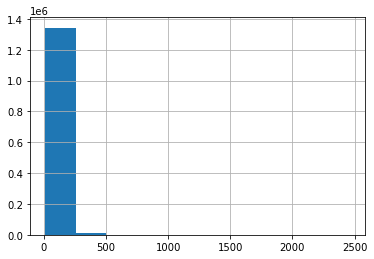

In [70]:
df_with_total_delay['Total_delay'].hist()

In [34]:
def getTime(t):
    if len(t) == 4:
        
        if t == "2400":
            t = "0000"
            
        t = t + '00' 
        return t[:2] + ':' + t[2:4] + ':' + t[4:]
    elif len(t) == 3:
    
        t = '0' + t + '00'
        return t[:2] + ':' + t[2:4] + ':' + t[4:]
    